<a href="https://colab.research.google.com/github/BHSF35/personal-blog/blob/main/Visual_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Search Engine
A demo of text-to-image similarity search using [OpenCLIP](https://github.com/mlfoundations/open_clip/) for vision and text feature extraction, and [faiss](https://github.com/facebookresearch/faiss/wiki) library for nearest neighbour search. Click `Runtime -> Change runtime type` and select `T4 GPU` to speed up the feature extraction process.

This notebook:
- Downloads 100 featured images from Wikimedia Commons
- Extracts vision embeddings using OpenCLIP
- Builds a FAISS `IndexFlatIP` (inner-product similarity)
- Accepts a text query from the user
- Retrieves and displays top‑5 similar images with filenames

In [ ]:
### 0. Install required libraries
!pip install -q open_clip_torch faiss-cpu pillow requests matplotlib

import os
from tqdm import tqdm
import requests
from PIL import Image
import torch
import open_clip
import faiss
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
### 1. Prepare a list of 16 Wikimedia Commons featured image URLs (add more if you want)
image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Kirchspiel%2C_R%C3%B6dder%2C_M%C3%A4usescheune_--_2014_--_2940-4.jpg/1280px-Kirchspiel%2C_R%C3%B6dder%2C_M%C3%A4usescheune_--_2014_--_2940-4.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/Dendrocygna_bicolor_wilhelma.jpg/1024px-Dendrocygna_bicolor_wilhelma.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/4/40/Sunflower_sky_backdrop.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Pyrrhula_pyrrhula_female_2.jpg/1024px-Pyrrhula_pyrrhula_female_2.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Tree_in_Mississippi.jpg/960px-Tree_in_Mississippi.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Deelerwoud%2C_09-05-2024_%28d.j.b.%29_16.jpg/1280px-Deelerwoud%2C_09-05-2024_%28d.j.b.%29_16.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Seebruecke_Prerow_002.jpg/1024px-Seebruecke_Prerow_002.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/Dragonblood_tree_in_Socotra_2.jpg/960px-Dragonblood_tree_in_Socotra_2.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Downy_woodpecker_in_GWC_%2833941%29.jpg/1024px-Downy_woodpecker_in_GWC_%2833941%29.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Ptilotula_fusca_-_Glen_Alice.jpg/1024px-Ptilotula_fusca_-_Glen_Alice.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Anna%27s_hummingbird_%2841124%29.jpg/1024px-Anna%27s_hummingbird_%2841124%29.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Bank_myna_%28Acridotheres_ginginianus%29.jpg/1024px-Bank_myna_%28Acridotheres_ginginianus%29.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/Village_weaver_%28Ploceus_cucullatus_cucullatus%29_female.jpg/960px-Village_weaver_%28Ploceus_cucullatus_cucullatus%29_female.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Rufous_Songlark_5779.jpg/1024px-Rufous_Songlark_5779.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Bloem_van_Convolvulus_cneorum_%28Zilverwinde%29._%28d.j.b.%29_02.jpg/1024px-Bloem_van_Convolvulus_cneorum_%28Zilverwinde%29._%28d.j.b.%29_02.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Bloem_van_een_Camellia_%C3%97_williamsii_%27Roger_Hall%27._20-04-2021_%28actm.%29_01.jpg/1280px-Bloem_van_een_Camellia_%C3%97_williamsii_%27Roger_Hall%27._20-04-2021_%28actm.%29_01.jpg"
]
assert len(image_urls) == 16

In [ ]:
### 2. Download images (only once) and save locally
import os
from tqdm import tqdm

os.makedirs("images", exist_ok=True)
local_paths = []
for idx, url in enumerate(tqdm(image_urls, desc="Downloading with wget")):
    filename = f"images/img_{idx:03d}.jpg"
    if not os.path.exists(filename):
        os.system(f"wget -q -O {filename} {url}")
    local_paths.append(filename)
print(local_paths)

In [ ]:
### 3. Load OpenCLIP model + preprocess pipeline
model_name = "ViT-B-32"
pretrained = "laion2b_s34b_b79k"
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device).eval()
tokenizer = open_clip.get_tokenizer(model_name)


In [ ]:
### 4. Encode all images to generate vision embeddings, store in numpy array
all_embeds = []
filenames = []
batch_size = 16
for i in tqdm(range(0, len(local_paths), batch_size), desc="Encoding images"):
    batch_paths = local_paths[i:i+batch_size]
    imgs = [preprocess(Image.open(p).convert("RGB")) for p in batch_paths]
    batch = torch.stack(imgs).to(device)
    with torch.no_grad():
        v = model.encode_image(batch)
        v = v / v.norm(dim=-1, keepdim=True)
    all_embeds.append(v.cpu().numpy())
    filenames.extend(batch_paths)
all_embeds = np.vstack(all_embeds).astype("float32")
print("Embeddings shape:", all_embeds.shape)


In [ ]:
### 5. Build FAISS index (IndexFlatIP for cosine similarity)
d = all_embeds.shape[1]
index = faiss.IndexFlatIP(d)
index.add(all_embeds)

In [ ]:
### 6. Define a search function: encode text query, search in FAISS index
def search_visual(query_text, top_k=5):
    tokens = tokenizer(["photo of a " + query_text])
    text_inputs = tokens.to(device)
    with torch.no_grad():
        txt_emb = model.encode_text(text_inputs)
        txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)
        txt_np = txt_emb.cpu().numpy().astype("float32")
    D, I = index.search(txt_np, top_k)
    results = [(filenames[idx], float(D[0, j])) for j, idx in enumerate(I[0])]
    return results



Enter your search query text: bird

Top‑5 Results:


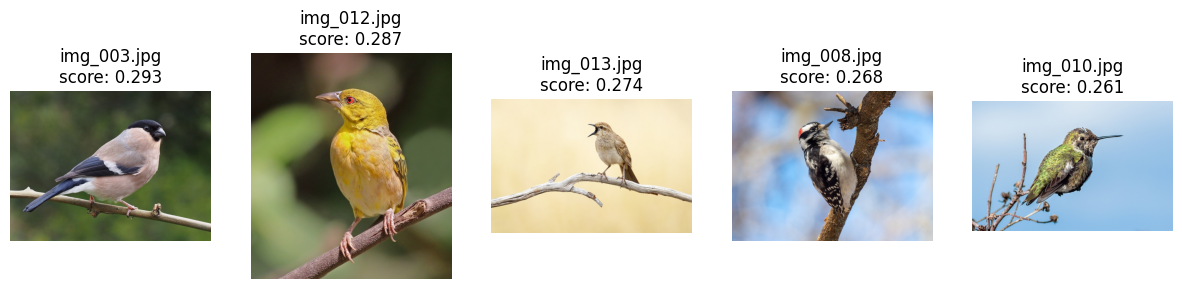

In [ ]:
### 7. Ask user for query and show top‑5 results
query = input("Enter your search query text (e.g. bird): ")
results = search_visual(query, top_k=5)

print("\nTop‑5 Results:")
plt.figure(figsize=(15, 6))
for i, (path, score) in enumerate(results):
    img = Image.open(path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    fname = os.path.basename(path)
    plt.title(f"{fname}\nscore: {score:.3f}")
plt.show()

